In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
import time
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import np_utils

/home/a70200/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

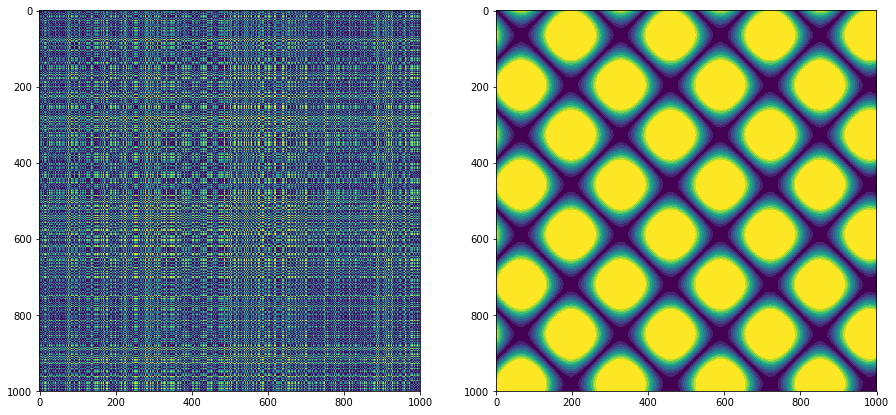

In [3]:
fig = plt.figure(figsize=(15,14))
random_series = np.random.random(1000)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(recurrence_plot(random_series[:,None]))
sinus_series = np.sin(np.linspace(0,24,1000))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(sinus_series[:,None]));

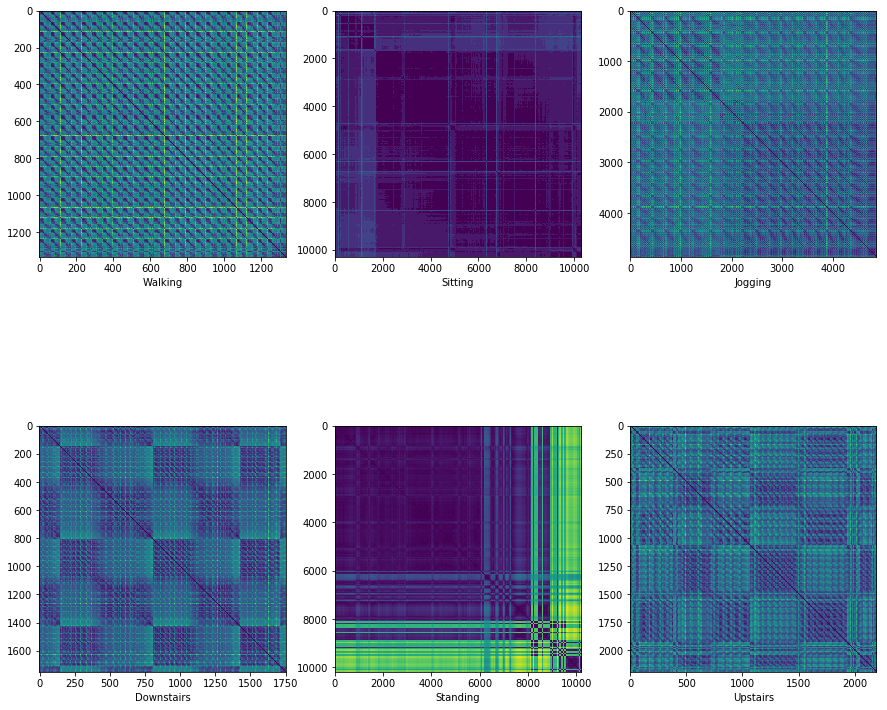

In [5]:
cols = ["attitude.roll","attitude.pitch","attitude.yaw","gravity.x","gravity.y","gravity.z","rotationRate.x","rotationRate.y","rotationRate.z","userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/wlk_15/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Walking')
ax = fig.add_subplot(2, 3, 2)
ax.imshow(recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/sit_5/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Sitting')
ax = fig.add_subplot(2, 3, 3)
ax.imshow(recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/jog_9/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Jogging')
ax = fig.add_subplot(2, 3, 4)
ax.imshow(recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Downstairs')
ax = fig.add_subplot(2, 3, 5)
ax.imshow(recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/std_6/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Standing')
ax = fig.add_subplot(2, 3, 6)
ax.imshow(recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/ups_3/sub_1.csv")[cols].values,steps=1000))
ax.set_xlabel('Upstairs');

In [7]:
# convert folders to class labels
# downstairs/upstairs = 0,walking/jogging  = 1, standing/sitting = 2
class_translate = {"dws_1" : 0, "dws_2" : 0, "dws_11" : 0,  \
                   "ups_3" : 0, "ups_4" : 0, "ups_12" : 0, \
                   "wlk_7" : 1, "wlk_8" : 1, "wlk_15" : 1, \
                   "jog_9" : 1, "jog_16" : 1, \
                   "std_6" : 2, "std_14" : 2, \
                   "sit_5" : 2, "sit_13": 2}

#pre allocate arrays
x_train = np.zeros((384,32,32))
y_train = np.zeros(384)
c = 0
start = time.time()
for i in class_translate.keys():    
    print("Processing set " + i)
    for j in range(1,25):
        dat = recurrence_plot(pd.read_csv("/home/a70200/Device_motion/A_DeviceMotion_data/A_DeviceMotion_data/" + i +"/" + "sub_"+ str(j) + ".csv")[cols].values, steps=100)
        dat = resize(dat, (32,32),mode='constant')
        x_train[c,:,:] = dat
        y_train[c] = class_translate[i]
        c = c + 1
end = time.time()
print('Elapsed time:')
print(end - start)

Processing set dws_1
Processing set dws_2
Processing set dws_11
Processing set ups_3
Processing set ups_4
Processing set ups_12
Processing set wlk_7
Processing set wlk_8
Processing set wlk_15
Processing set jog_9
Processing set jog_16
Processing set std_6
Processing set std_14
Processing set sit_5
Processing set sit_13
Elapsed time:
185.30866241455078


In [9]:
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 30, 30)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 15, 30)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 15, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 13, 32)        8672      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 6, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1344)              0         
__________

In [10]:
#reshape to include depth
X_train = x_train.reshape(x_train.shape[0], 1, 32,32)
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
# convert labels to class matrix, one-hot-encoding
Y_train = np_utils.to_categorical(y_train, 3)
# split in train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [11]:
model.fit(X_train, Y_train, epochs=200, batch_size=16,shuffle=True)

Epoch 1/200
345/345 [==============================] - 1s 3ms/step - loss: 0.9997 - acc: 0.3884
Epoch 2/200
345/345 [==============================] - 0s 385us/step - loss: 0.9083 - acc: 0.5420
Epoch 3/200
345/345 [==============================] - 0s 427us/step - loss: 0.8348 - acc: 0.5826
Epoch 4/200
345/345 [==============================] - 0s 410us/step - loss: 0.8131 - acc: 0.5855
Epoch 5/200
345/345 [==============================] - 0s 384us/step - loss: 0.7826 - acc: 0.5710
Epoch 6/200
345/345 [==============================] - 0s 408us/step - loss: 0.7536 - acc: 0.5797
Epoch 7/200
345/345 [==============================] - 0s 436us/step - loss: 0.7331 - acc: 0.6174
Epoch 8/200
345/345 [==============================] - 0s 414us/step - loss: 0.7287 - acc: 0.6145
Epoch 9/200
345/345 [==============================] - 0s 432us/step - loss: 0.7165 - acc: 0.5913
Epoch 10/200
345/345 [==============================] - 0s 429us/step - loss: 0.6740 - acc: 0.6551
Epoch 11/200
345/345 

345/345 [==============================] - 0s 431us/step - loss: 0.3178 - acc: 0.8203
Epoch 84/200
345/345 [==============================] - 0s 386us/step - loss: 0.2995 - acc: 0.8551
Epoch 85/200
345/345 [==============================] - 0s 432us/step - loss: 0.3050 - acc: 0.8638
Epoch 86/200
345/345 [==============================] - 0s 426us/step - loss: 0.3072 - acc: 0.8870
Epoch 87/200
345/345 [==============================] - 0s 449us/step - loss: 0.2999 - acc: 0.8841
Epoch 88/200
345/345 [==============================] - 0s 415us/step - loss: 0.3002 - acc: 0.8812
Epoch 89/200
345/345 [==============================] - 0s 421us/step - loss: 0.2613 - acc: 0.8609
Epoch 90/200
345/345 [==============================] - 0s 430us/step - loss: 0.2953 - acc: 0.8812
Epoch 91/200
345/345 [==============================] - 0s 382us/step - loss: 0.2836 - acc: 0.8638
Epoch 92/200
345/345 [==============================] - 0s 414us/step - loss: 0.2590 - acc: 0.8667
Epoch 93/200
345/345 [=

345/345 [==============================] - 0s 423us/step - loss: 0.1157 - acc: 0.9507
Epoch 166/200
345/345 [==============================] - 0s 430us/step - loss: 0.1658 - acc: 0.9159
Epoch 167/200
345/345 [==============================] - 0s 408us/step - loss: 0.1220 - acc: 0.9420
Epoch 168/200
345/345 [==============================] - 0s 429us/step - loss: 0.1143 - acc: 0.9507
Epoch 169/200
345/345 [==============================] - 0s 436us/step - loss: 0.1009 - acc: 0.9507
Epoch 170/200
345/345 [==============================] - 0s 439us/step - loss: 0.1084 - acc: 0.9478
Epoch 171/200
345/345 [==============================] - 0s 422us/step - loss: 0.1356 - acc: 0.9333
Epoch 172/200
345/345 [==============================] - 0s 401us/step - loss: 0.0839 - acc: 0.9710
Epoch 173/200
345/345 [==============================] - 0s 418us/step - loss: 0.1074 - acc: 0.9565
Epoch 174/200
345/345 [==============================] - 0s 396us/step - loss: 0.0940 - acc: 0.9565
Epoch 175/200


In [12]:
predictions= model.predict(x_test)
rounded = [np.argmax(x) for x in predictions]
print(K.eval(metrics.categorical_accuracy(y_test, np_utils.to_categorical(rounded, 3))))

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
